# Personal Information
Name: **Stijn Lakeman**

StudentID: **12816094**

Email: [**stijnlakeman@gmail.com**](stijnlakeman@gmail.com)

GitHub: [**https://github.com/St0neLake/MIL-for-Multi-Task-Speaker-Attribute-Prediction**](https://github.com/St0neLake/MIL-for-Multi-Task-Speaker-Attribute-Prediction)

Submitted on: **23.03.2025**

# Data Context
This dataset contains structured information about political figures from the United States Congress. It includes biographical metadata such as name, state, gender, and party affiliation, as well as the speeches they gave. Each row in the dataset represents a single speaker and contains the given speeches, along with summary statistics like their age and number of speeches.

The data spans multiple sessions of Congress and includes members from both the House of Representatives and the Senate. It is suitable for linguistic, demographic, or political analysis, especially focused on the relationship between speaker background and spoken content.

# Data Description (columns)

| Column          | Description |
|------------------|-------------|
| `speakerid`      | Unique ID assigned to each speaker |
| `state`          | Two-letter U.S. state code (e.g., NV, CA) |
| `gender`         | Speaker's gender (e.g., M, F) |
| `party`          | Speaker's political party (e.g., D, R) |
| `chamber`        | Chamber of Congress: ‘S’ for Senate, ‘H’ for House |
| `firstname`      | Speaker's first name |
| `lastname`       | Speaker's last name |
| `middlename`     | Speaker's middle name (if available) |
| `suffix`         | Suffix to the speaker's name (e.g., Jr., III) |
| `birthday`       | Date of birth of the speaker |
| `termstart`      | Start date of the speaker’s current term |
| `age`            | Age of the speaker at the time of data collection |
| `incumbent`      | Boolean indicator of whether the speaker is currently in office |
| `congress`       | Numeric representation of the congressional session (e.g., 117) |
| `bioguide`       | Unique BioGuide identifier for external linkage |
| `num_speeches`   | Number of speech segments recorded for the speaker |
| `text`           | A list of individual speech segments (utterances) as a single stringified Python list |


In [1]:
import pandas as pd
import numpy as np
# Optional: for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import random

### Data Loading

In [2]:
df = pd.read_csv("../RL-MIL-main/data/political_data.csv")
# Convert stringified speech lists to Python lists
df['text'] = df['text'].apply(ast.literal_eval)

### Analysis 1: 
We'll start by checking out the overall shape of the data, things like data types, missing values, and the number of entries. After that, we’ll dive into some speaker statistics, including how many utterances each speaker has, the distribution of political parties and gender, and take a look at a few example bags to know what the bags look like.

This helps us understand whether the dataset is clean, balanced, and ready for modeling.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   speakerid     8521 non-null   int64  
 1   state         8521 non-null   object 
 2   gender        8521 non-null   object 
 3   party         8521 non-null   object 
 4   chamber       8521 non-null   object 
 5   firstname     8521 non-null   object 
 6   lastname      8521 non-null   object 
 7   text          8521 non-null   object 
 8   congress      8521 non-null   int64  
 9   bioguide      8521 non-null   object 
 10  middlename    6166 non-null   object 
 11  suffix        764 non-null    object 
 12  birthday      8521 non-null   object 
 13  incumbent     8521 non-null   object 
 14  termstart     8521 non-null   object 
 15  age           8521 non-null   float64
 16  num_speeches  8521 non-null   int64  
dtypes: float64(1), int64(3), object(13)
memory usage: 1.1+ MB


In [4]:
df.head()

,speakerid,state,gender,party,chamber,firstname,lastname,text,congress,bioguide,middlename,suffix,birthday,incumbent,termstart,age,num_speeches
0,97104041,NV,M,D,S,Howard,Cannon,[Mr. President. I am pleased to introduce the ...,97,C000120,Walter,NaN,1912-01-26,Yes,1981-01-05,68.9,364
1,97104231,CA,M,R,S,Samuel,Hayakawa,[Mr. President. today I am introducing a bill ...,97,H000384,Ichiye,NaN,1906-07-18,Yes,1981-01-05,74.5,546
2,97104561,NM,M,R,S,Harrison,Schmitt,[Mr. President. today I am introducing a bill ...,97,S000132,Hagan,NaN,1935-07-03,Yes,1981-01-05,45.5,899
3,97104711,NJ,M,D,S,Harrison,Williams,[Mr. President. I am confident that all of my ...,97,W000502,Arlington,Jr.,1919-12-10,Yes,1981-01-05,61.1,151
4,97104811,TN,M,R,S,Howard,Baker,[Mr. President. I suggest the absence of a quo...,97,B000063,Henry,Jr.,1925-11-15,Yes,1981-01-05,55.1,15456


In [5]:
df['chamber'].value_counts()

chamber
H    6878
S    1643
Name: count, dtype: int64

In [6]:
df['party'].value_counts()

party
D    4496
R    4025
Name: count, dtype: int64

In [7]:
df['gender'].value_counts()

gender
M    7693
F     828
Name: count, dtype: int64

In [8]:
df['age'].describe()

count    8521.000000
mean       54.231440
std        10.603619
min        26.400000
25%        46.500000
50%        54.000000
75%        61.500000
max        98.100000
Name: age, dtype: float64

In [9]:
df['num_speeches'].describe()

count     8521.000000
mean       275.509682
std        544.933887
min          1.000000
25%         64.000000
50%        140.000000
75%        311.000000
max      21142.000000
Name: num_speeches, dtype: float64

In [10]:
sample = df.iloc[3]
print("Speaker:", sample['firstname'], sample['lastname'])
print("Party:", sample['party'])
print("Number of Speeches:", sample['num_speeches'])
print("Utterances:")

for i, utterance in enumerate(sample['text'][:2]):
    print(f"{i+1}. {utterance}")

Speaker: Harrison Williams
Party: D
Number of Speeches: 151
Utterances:
1. Mr. President. I am confident that all of my colleagues will support the motion to confirm Dick Schweiker as Secretary of Health and Human Services. ITE S403 My confidence is borne not only of the affection I have for him personally. but also of the admiration and esteem that he has so gracefully acquired during his years as a Member of the Senate. When he was sworn in as a Senator in 196. he was assigned to membership on the Committee on Labor and Public Welfare. I too was a member of that committee and chairman of the Subcommittee on Labor. I marked him immediately as a person of exceptional energy. ranging curiosity. eloquence. compassion. and determination to find the best solution to the problems of people. Over these past 12 years. my initial impression has been confirmed many times. Dick Schweiker has been an important part of the foundation for all of the committees work during the past decade. During th

Overall, the dataset is well-structured, complete, and has a good variety of speaker metadata and bag sizes. There is some imbalance in gender and chamber representation, but this reflects historical reality rather than data issues. The null values in the middle name and suffix, make since since not everyone has a middle name, or a suffix, these are also not necessary for the predictions. The text column confirms that utterances are parsed into tokenized lists, making the data ready for instance-level learning.

### Bag Size (Number of Speeches per Speaker): 

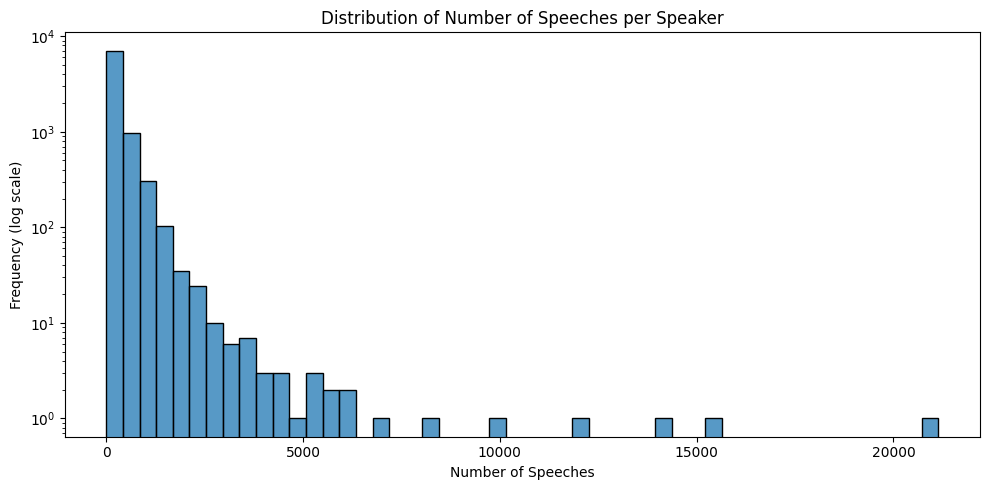

In [11]:
# Plot distribution of num_speeches per speaker
plt.figure(figsize=(10, 5))
sns.histplot(df['num_speeches'], bins=50, log_scale=(False, True))
plt.title('Distribution of Number of Speeches per Speaker')
plt.xlabel('Number of Speeches')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()

As we can see, most speakers contribute a small number of speeches, while a few speakers are very active, with over 20,000  speeches. This kind of skewed distribution is pretty normal in political context and something to keep in mind when designing sampling or instance selection strategies later on. We might also have to consider whether to normalize or cap very large bags to avoid them dominating the learning process.

### Speaker Age Distribution:

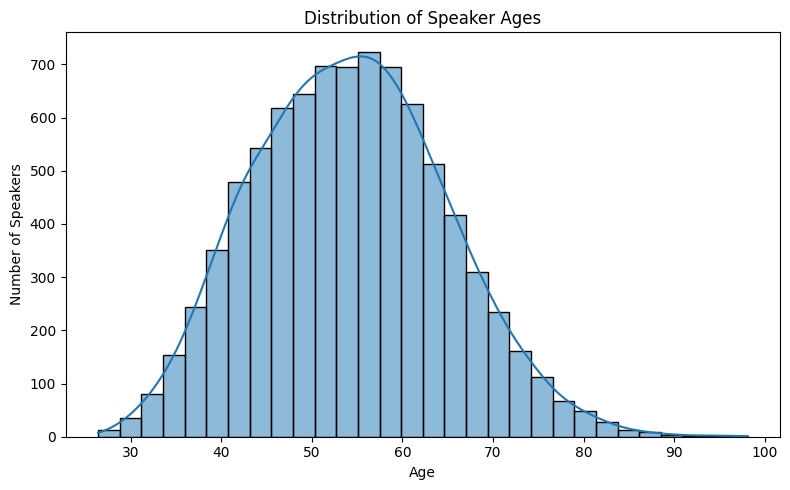

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Speaker Ages')
plt.xlabel('Age')
plt.ylabel('Number of Speakers')
plt.tight_layout()
plt.show()

The speaker age distribution follows a roughly normal curve, having the biggest peak around age 55. Most speakers fall between 40 and 70 years old, with very few younger than 30 or older than 80. This makes sense given the age demographics of the U.S. Congress members and confirms that we have a realistic and fairly concentrated age range to work with for modeling.

### Party and Gender Breakdown:

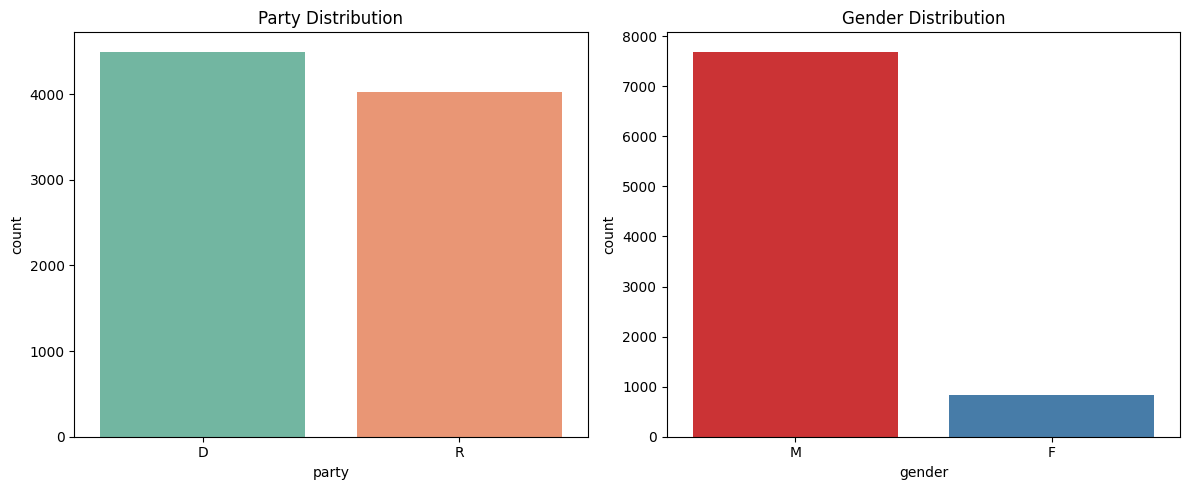

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Party distribution
sns.countplot(ax=axes[0], x='party', data=df, palette='Set2')
axes[0].set_title('Party Distribution')

# Gender distribution
sns.countplot(ax=axes[1], x='gender', data=df, palette='Set1')
axes[1].set_title('Gender Distribution')

plt.tight_layout()
plt.show()

The party distribution is relatively balanced, with a slight majority of Democratic speakers over Republicans. This balance is helpful when training models that involve party prediction, as there is almost no class imbalance.

On the other hand, gender distribution is heavily skewed: the majority of speakers are male. This reflects historical underrepresentation of women in U.S. Congress, but it’s important to keep in mind, especially when evaluating fairness or training models for gender-based tasks. Any performance differences could be because of this imbalance.

## 3.3 Utterance-Level Exploration

Now we will focus on the content of the speeches themselves. Specifically, we want to get a better idea of what the utterances look like, how long they are, and how much variability exists across speakers.

This is helpful for several reasons:
- It tells us how consistent or noisy the text data might be
- It helps decide whether preprocessing (like tokenization or truncation) is needed
- It gives an early impression of the linguistic style and complexity of the data

In [14]:
# Flatten all utterances and compute their lengths (in words)
utterance_lengths = df['text'].explode().dropna().apply(lambda x: len(x.split()))

# Basic stats
utterance_lengths.describe()

count    2.347618e+06
mean     2.153580e+02
std      4.428418e+02
min      1.000000e+00
25%      1.300000e+01
50%      4.100000e+01
75%      2.380000e+02
max      2.142200e+04
Name: text, dtype: float64

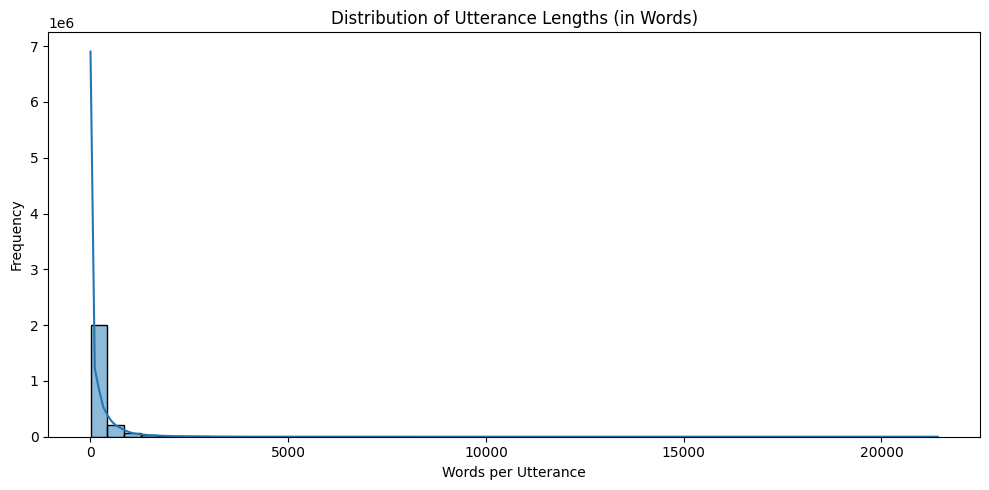

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(utterance_lengths, bins=50, kde=True)
plt.title("Distribution of Utterance Lengths (in Words)")
plt.xlabel("Words per Utterance")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

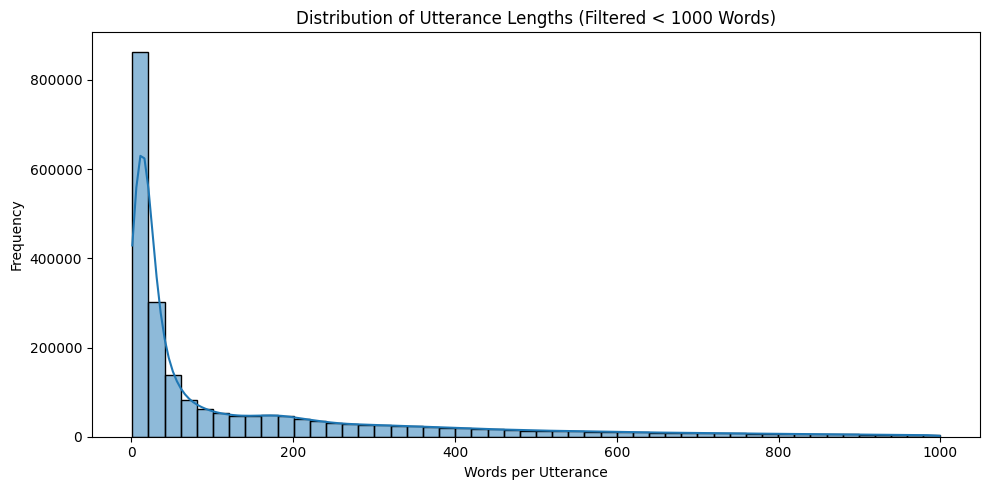

In [16]:
# Filter out very long utterances for a clearer view (e.g., cap at 1000 words)
filtered_lengths = utterance_lengths[utterance_lengths < 1000]

# Plot the filtered distribution
plt.figure(figsize=(10, 5))
sns.histplot(filtered_lengths, bins=50, kde=True)
plt.title("Distribution of Utterance Lengths (Filtered < 1000 Words)")
plt.xlabel("Words per Utterance")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Most of the utterances are fairly short, most fall under 100 words, with a sharp drop-off after that. There are still a noticeable number of medium-length utterances (100–300 words), and a long tail of rare but very long ones. This suggests the dataset has a mix of brief statements and more extended speeches.

For modeling, it might be worth truncating or clipping extremely long utterances, especially if using models with input length limits (like transformers). The distribution also shows that most bags are dominated by short to moderately long segments, which can help guide sampling or weighting strategies later on.

## Text Preprocessing and Token-Level Exploration
Now we will do some basic cleaning and look at Basic token frequency and vocabulary size.

In [17]:
# Define a quick cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation and numbers
    text = re.sub(r"\s+", " ", text)      # remove extra whitespace
    return text.strip()

# Apply it to a small sample
sample_clean = clean_text(df['text'].explode().dropna().iloc[0])
print(sample_clean[:800])

mr president i am pleased to introduce the product liability risk retention act a bill that would allow manufacturers wholesaledistributors and retailers to establish product liability risk retention groups and to purchase product liability insurance on a group basis this bill provides a miu l rceded alternative solution to an immediate problem facing all product sellers todaythe opportunity to secure protection against product liability loss at reasonable rates the bill i am introducing today is the bill reported by the commerce committee late in the last session of congress it reflects substantial amendments made by the committee on the basis of the hearings in the th congress i hope that this legislation will be considered early in the th congress adoption by the state courts of new and


In [18]:
# Tokenize and flatten cleaned utterances
cleaned_tokens = df['text'].explode().dropna().apply(clean_text).str.split().explode()

# Count most frequent tokens
token_counts = cleaned_tokens.value_counts()
token_counts.head(20)

text
the     33222493
to      17409612
of      15697975
and     13174395
in      10036520
that     9937244
a        8920961
i        7833457
is       7442150
we       5875786
this     5840642
for      5386771
it       4856775
have     4147546
on       4055526
are      3668126
not      3436328
be       3383442
as       2950422
with     2694700
Name: count, dtype: int64

As expected, the most frequent tokens are common English stopwords like "the", "to", "of", and "and". This suggests that a large portion of the vocabulary is function words, which may not carry much semantic information for tasks like speaker attribute prediction. Depending on the modeling approach, it could be beneficial to filter out stopwords. That said, some stopwords (like "we", "I", or "not") could still carry stylistic or personal relevance in a political context, so any cleaning should be done thoughtfully.

In [19]:
# Download stopwords if needed
nltk.download('stopwords')

# Define the stopword list
stop_words = set(stopwords.words('english'))

# Filter tokens
filtered_tokens = cleaned_tokens[~cleaned_tokens.isin(stop_words)]

# Top 20 content words
filtered_tokens.value_counts().head(20)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stijn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


text
mr           2662323
would        2041983
president    1744786
bill         1667923
us           1242378
time         1203406
people       1147938
amendment    1138884
one          1037527
senator       999655
speaker       937471
states        840652
committee     824240
years         812609
year          807254
going         766846
gentleman     763962
chairman      759636
senate        748346
think         745484
Name: count, dtype: int64

In [20]:
filtered_vocab_size = filtered_tokens.nunique()
print(f"Vocabulary size without stopwords: {filtered_vocab_size:,} unique tokens")

Vocabulary size without stopwords: 1,690,437 unique tokens


In [21]:
# Keep important personal/pragmatic words
keep_words = {"we", "i", "not"}

# Remove them from the stopword list
custom_stopwords = stop_words - keep_words

# Re-filter tokens
filtered_tokens_custom = cleaned_tokens[~cleaned_tokens.isin(custom_stopwords)]

# Re-check top words
filtered_tokens_custom.value_counts().head(20)

text
i            7833457
we           5875786
not          3436328
mr           2662323
would        2041983
president    1744786
bill         1667923
us           1242378
time         1203406
people       1147938
amendment    1138884
one          1037527
senator       999655
speaker       937471
states        840652
committee     824240
years         812609
year          807254
going         766846
gentleman     763962
Name: count, dtype: int64

After filtering out stopwords, we get a clearer sense of what language appears the most in the dataset. Terms like "mr", "president", "bill", "senator", and "amendment" reflect the formal setting of congressional speech, while words like "people", "committee", and "states" might offer cues about political orientation or topical focus.

With over 1.6 million unique tokens remaining after stopword removal, there is still a lot variety. This filtered vocabulary is likely to be more informative for speaker-level prediction tasks, especially when using models that rely on discriminative word patterns to predict age, gender, or party affiliation.

To avoid removing potentially meaningful signals, we retained certain high-impact words like *“I”*, *“we”*, and *“not”*. These words could be relevant in the context of speaker identity, for example, expressing individual vs. collective viewpoints or signaling opposition. Keeping these in the vocabulary allows the model (especially in MIL + MTL setups) to better capture stylistic and ideological cues embedded in the speaker's language.

## Group-Based Token Analysis (Party & Gender)

In this section, we explore how word usage varies between different speaker groups. We use sampling here to avoid memory issues caused by exploding all utterances across the full dataset. Sampling 300 speakers per group will still give a representative view of token usage patterns.

In [22]:
# Sample 300 Democrat and 300 Republican speakers
dem_sample = df[df['party'] == 'D'].sample(n=300, random_state=42)
rep_sample = df[df['party'] == 'R'].sample(n=300, random_state=42)

# Combine and explode
sampled_party_df = pd.concat([dem_sample, rep_sample])
exploded_party = sampled_party_df[['party', 'text']].explode('text').dropna()
exploded_party['cleaned'] = exploded_party['text'].apply(clean_text)
exploded_party['tokens'] = exploded_party['cleaned'].apply(
    lambda x: [t for t in x.split() if t not in custom_stopwords]
)

# Token counts
dem_tokens = exploded_party[exploded_party['party'] == 'D']['tokens'].explode()
rep_tokens = exploded_party[exploded_party['party'] == 'R']['tokens'].explode()

dem_counts = dem_tokens.value_counts().head(20)
rep_counts = rep_tokens.value_counts().head(20)

# Combine into one table
party_comparison = pd.concat([dem_counts.rename('Democrat'), rep_counts.rename('Republican')], axis=1).fillna(0)
party_comparison


,Democrat,Republican
tokens,,
i,307654,281140
we,235848,220711
not,135079,124175
mr,101708,88580
would,78822,76016
president,72169,63154
bill,66667,63656
us,48916,44074
people,46845,43891


In [23]:
# Repeat for gender
# Sample 300 male and 300 female speakers
male_sample = df[df['gender'] == 'M'].sample(n=300, random_state=42)
female_sample = df[df['gender'] == 'F'].sample(n=300, random_state=42)

# Combine and explode
sampled_gender_df = pd.concat([male_sample, female_sample])
exploded_gender = sampled_gender_df[['gender', 'text']].explode('text').dropna()
exploded_gender['cleaned'] = exploded_gender['text'].apply(clean_text)
exploded_gender['tokens'] = exploded_gender['cleaned'].apply(lambda x: [t for t in x.split() if t not in custom_stopwords])

# Token counts
male_tokens = exploded_gender[exploded_gender['gender'] == 'M']['tokens'].explode()
female_tokens = exploded_gender[exploded_gender['gender'] == 'F']['tokens'].explode()

male_counts = male_tokens.value_counts().head(20)
female_counts = female_tokens.value_counts().head(20)

# Combine into one table
gender_comparison = pd.concat([male_counts.rename('Male'), female_counts.rename('Female')], axis=1).fillna(0)
gender_comparison

,Male,Female
tokens,,
i,247490.0,193076.0
we,189757.0,158677.0
not,106203.0,78500.0
mr,86135.0,60497.0
would,63577.0,47942.0
president,54355.0,26759.0
bill,49912.0,48559.0
time,38835.0,29985.0
us,37446.0,36153.0


In [30]:
# Get top-N most frequent words across both groups (combined)
top_n = 50

# Combine all token counts
combined_party = pd.concat([dem_counts, rep_counts], axis=1).fillna(0)
combined_party.columns = ['Democrat', 'Republican']
combined_party['diff'] = abs(combined_party['Democrat'] - combined_party['Republican'])
top_party_diff_words = combined_party.sort_values(by='diff', ascending=False).head(top_n)

combined_gender = pd.concat([male_counts, female_counts], axis=1).fillna(0)
combined_gender.columns = ['Male', 'Female']
combined_gender['diff'] = abs(combined_gender['Male'] - combined_gender['Female'])
top_gender_diff_words = combined_gender.sort_values(by='diff', ascending=False).head(top_n)

# Compare overlap in high-difference words
party_diff_set = set(top_party_diff_words.index)
gender_diff_set = set(top_gender_diff_words.index)
shared_differences = party_diff_set & gender_diff_set

print("Words with large usage differences in both party and gender groups:")
print(shared_differences)
print(f"\nCount: {len(shared_differences)} shared discriminative words")

Words with large usage differences in both party and gender groups:
{'senator', 'people', 'president', 'years', 'time', 'one', 'going', 'states', 'speaker', 'we', 'not', 'amendment', 'year', 'bill', 'us', 'would', 'committee', 'mr', 'i'}

Count: 19 shared discriminative words


By analyzing token usage across sampled speakers from different political parties and genders, we can see consistent patterns in how language varies between these groups. Also, 19 tokens, including words like "i", "we", "amendment", "president", and "senator", showed large usage differences in both party and gender comparisons.

This overlap suggests that certain linguistic features carry shared predictive signal across tasks, making them potentially good candidates for shared representations in a MTL framework. At the same time, the presence of group-specific tokens reinforces the need for task-specific components or task clustering to account for non-shared patterns.


## EDA Summary

This exploratory data analysis provided a detailed look into the structure, content, and linguistic patterns of the political speech dataset. The key findings align with the goals of this thesis, which focuses on using MTL and RL-MIL for speaker attribute prediction.

### Key Points:

- **Structured Speaker Data**: Each speaker is associated with a bag of utterances, making this dataset well-suited for Multiple Instance Learning (MIL). Demographic and political metadata (e.g., age, gender, party, chamber) are consistently available.

- **Speech Content**: The dataset includes a wide variety of utterance lengths, with a long tail of very large bags. Most utterances are formal and context-specific, reflecting the congressional setting.

- **Stopword Handling**: Custom stopword filtering helped preserve meaningful words like *“I”*, *“we”*, and *“not”*, which are stylistically and semantically relevant for speaker profiling (more words might need to be added).

- **Token-Level Differences Across Attributes**: Clear differences in word usage were found between speaker groups based on **party** and **gender**.

- **Shared Signal Across Tasks**: A significant overlap in discriminative words across party and gender suggests the presence of **shared linguistic representations**, a strong argument in favor of MTL.

### Impact on Modeling

This analysis shows:
- Speaker attributes do influence linguistic patterns in a measurable way.
- There is both **shared** and **task-specific** signal, supporting the use of **MTL with task clustering**.
- The MIL structure is appropriate, with variable-length bags and speaker-level labels.
